# Coral Experiments : up-sampling task

This notebook presents the up-sampling capabilities of the CORAL framework. **This notebook requires that models have already been trained.**

In [1]:
!nvidia-smi

import sys
sys.executable

Wed May 10 15:03:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.64       Driver Version: 525.89.02    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:13:00.0 Off |                  N/A |
|  0%   20C    P8    13W / 370W |    231MiB / 10240MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

'/data/lise.leboudec/conda/envs/coral/bin/python'

## Initialization 

In [2]:
import torch
import torch.nn as nn
import time
import hydra
import wandb
import einops
from pathlib import Path
import os
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

from expe.forwards.forwards_inr import forward_dino, forward_coral
from omegaconf import DictConfig, OmegaConf
from coral.utils.data.load_data import get_dynamics_data, set_seed
from coral.utils.data.dynamics_dataset import TemporalDatasetWithCode, KEY_TO_INDEX
from template.ode_dynamics import DetailedMSE
from dino.ode_model import Decoder
from dino.ode_model import Derivative as Derivative_dino
from coral.utils.data.load_modulations import load_dynamics_modulations
from coral.utils.models.scheduling import ode_scheduling
from coral.utils.models.load_inr import create_inr_instance, load_inr_model
from coral.mlp import Derivative as Derivative_coral

ImportError: cannot import name 'forward_dino' from 'expe.forwards' (unknown location)

### Load config

In [4]:
cuda = torch.cuda.is_available()
if cuda:
    gpu_id = torch.cuda.current_device()
    device = torch.device(f"cuda:{gpu_id}")
else:
    device = torch.device("cpu")
print("device : ", device)

device :  cuda:0


In [5]:
data_dir = "/data/serrano/"
dataset_name = 'navier-stokes-dino'
root_dir = Path(os.getenv("WANDB_DIR")) / dataset_name
inr_run_name = "fearless-sky-3319"
dyn_run_name = "valiant-dust-3361"
dino_run_name = "noble-lake-3671"

In [6]:
cfg_coral_dyn = torch.load(root_dir / "model" / f"{dyn_run_name}.pt")['cfg']
cfg_coral_inr = torch.load(root_dir / "inr" / f"{inr_run_name}.pt")['cfg']

In [7]:
# data
ntrain = cfg_coral_dyn.data.ntrain
ntest = cfg_coral_dyn.data.ntest
data_to_encode = cfg_coral_dyn.data.data_to_encode
sub_from = cfg_coral_dyn.data.sub_from
sub_tr = cfg_coral_dyn.data.sub_tr
sub_te = cfg_coral_dyn.data.sub_te
seed = cfg_coral_dyn.data.seed
same_grid = cfg_coral_dyn.data.same_grid
setting = cfg_coral_dyn.data.setting
sequence_length_optim = None
sequence_length_in = cfg_coral_dyn.data.sequence_length_in
sequence_length_out = cfg_coral_dyn.data.sequence_length_out

print(f"running in setting {setting} with sampling {sub_from} / {sub_tr} - {sub_te}")

# dino
n_steps = 300
lr_adapt = 0.005

# coral
code_dim_coral = cfg_coral_inr.inr.latent_dim
width_dyn_coral = cfg_coral_dyn.dynamics.width
depth_dyn_coral = cfg_coral_dyn.dynamics.depth

# optim
batch_size = 1
batch_size_val = 1
criterion = nn.MSELoss()

if dataset_name == 'shallow-water-dino':
    multichannel = True
else:
    multichannel = False

running in setting extrapolation with sampling 4 / 0.25 - 0.25


In [8]:
# experiments
sub_from1 = 4
sub_from2 = 2
sub_from3 = 1

### Load data

In [9]:
set_seed(seed)

(u_train, u_test, grid_tr, grid_te, _, _, _, _, u_train_ext, u_test_ext, grid_tr_ext, grid_te_ext) = get_dynamics_data(
    data_dir,
    dataset_name,
    ntrain,
    ntest,
    sequence_length=sequence_length_optim,
    sub_from=sub_from,
    sub_tr=sub_tr,
    sub_te=sub_te,
    same_grid=same_grid,
    setting=setting,
    sequence_length_in=sequence_length_in,
    sequence_length_out=sequence_length_out
)

(_, _, _, _, _, _, _, _, u_train_up1, u_test_up1, grid_tr_up1, grid_te_up1) = get_dynamics_data(
    data_dir,
    dataset_name,
    ntrain,
    ntest,
    sequence_length=sequence_length_optim,
    sub_from=sub_from1,
    sub_tr=1,
    sub_te=1,
    same_grid=same_grid,
    setting=setting,
    sequence_length_in=sequence_length_in,
    sequence_length_out=sequence_length_out
)

(_, _, _, _, _, _, _, _, u_train_up4, u_test_up4, grid_tr_up4, grid_te_up4) = get_dynamics_data(
    data_dir,
    dataset_name,
    ntrain,
    ntest,
    sequence_length=sequence_length_optim,
    sub_from=sub_from2,
    sub_tr=1,
    sub_te=1,
    same_grid=same_grid,
    setting=setting,
    sequence_length_in=sequence_length_in,
    sequence_length_out=sequence_length_out
)

(_, _, _, _, _, _, _, _, u_train_up16, u_test_up16, grid_tr_up16, grid_te_up16) = get_dynamics_data(
    data_dir,
    dataset_name,
    ntrain,
    ntest,
    sequence_length=sequence_length_optim,
    sub_from=sub_from3,
    sub_tr=1,
    sub_te=1,
    same_grid=same_grid,
    setting=setting,
    sequence_length_in=sequence_length_in,
    sequence_length_out=sequence_length_out
)

# flatten spatial dims
u_train = einops.rearrange(u_train, 'B ... C T -> B (...) C T')
grid_tr = einops.rearrange(grid_tr, 'B ... C T -> B (...) C T')  
u_test = einops.rearrange(u_test, 'B ... C T -> B (...) C T')
grid_te = einops.rearrange(grid_te, 'B ... C T -> B (...) C T')  
if u_train_ext is not None:
    u_train_ext = einops.rearrange(u_train_ext, 'B ... C T -> B (...) C T')
    grid_tr_ext = einops.rearrange(
        grid_tr_ext, 'B ... C T -> B (...) C T')  
    u_test_ext = einops.rearrange(u_test_ext, 'B ... C T -> B (...) C T')
    grid_te_ext = einops.rearrange(
        grid_te_ext, 'B ... C T -> B (...) C T')  
if u_train_up1 is not None:
    u_train_up1 = einops.rearrange(u_train_up1, 'B ... C T -> B (...) C T')
    grid_tr_up1 = einops.rearrange(
        grid_tr_up1, 'B ... C T -> B (...) C T')  
    u_test_up1 = einops.rearrange(u_test_up1, 'B ... C T -> B (...) C T')
    grid_te_up1 = einops.rearrange(
        grid_te_up1, 'B ... C T -> B (...) C T') 
if u_train_up4 is not None:
    u_train_up4 = einops.rearrange(u_train_up4, 'B ... C T -> B (...) C T')
    grid_tr_up4 = einops.rearrange(
        grid_tr_up4, 'B ... C T -> B (...) C T')  
    u_test_up4 = einops.rearrange(u_test_up4, 'B ... C T -> B (...) C T')
    grid_te_up4 = einops.rearrange(
        grid_te_up4, 'B ... C T -> B (...) C T') 
if u_train_up16 is not None:
    u_train_up16 = einops.rearrange(u_train_up16, 'B ... C T -> B (...) C T')
    grid_tr_up16 = einops.rearrange(
        grid_tr_up16, 'B ... C T -> B (...) C T')  
    u_test_up16 = einops.rearrange(u_test_up16, 'B ... C T -> B (...) C T')
    grid_te_up16 = einops.rearrange(
        grid_te_up16, 'B ... C T -> B (...) C T') 

print(
    f"data: {dataset_name}, u_train: {u_train.shape}, u_test: {u_test.shape}")
print(f"grid: grid_tr: {grid_tr.shape}, grid_te: {grid_te.shape}")
if u_train_ext is not None:
    print(
        f"data: {dataset_name}, u_train_ext: {u_train_ext.shape}, u_test_ext: {u_test_ext.shape}")
    print(
        f"grid: grid_tr_ext: {grid_tr_ext.shape}, grid_te_ext: {grid_te_ext.shape}")


data: navier-stokes-dino, u_train: torch.Size([256, 1024, 1, 20]), u_test: torch.Size([16, 1024, 1, 20])
grid: grid_tr: torch.Size([256, 1024, 2, 20]), grid_te: torch.Size([16, 1024, 2, 20])
data: navier-stokes-dino, u_train_ext: torch.Size([256, 1024, 1, 40]), u_test_ext: torch.Size([16, 1024, 1, 40])
grid: grid_tr_ext: torch.Size([256, 1024, 2, 40]), grid_te_ext: torch.Size([16, 1024, 2, 40])


In [10]:
n_seq_train = u_train.shape[0]  # 512 en dur
n_seq_test = u_test.shape[0]  # 512 en dur
spatial_size = u_train.shape[1]  # 64 en dur
state_dim = u_train.shape[2]  # N, XY, C, T
coord_dim = grid_tr.shape[2]  # N, XY, C, T
T = u_train.shape[-1]

ntrain = u_train.shape[0]  # int(u_train.shape[0]*T)
ntest = u_test.shape[0]  # int(u_test.shape[0]*T)


In [11]:
trainset = TemporalDatasetWithCode(
    u_train, grid_tr, code_dim_coral, dataset_name, data_to_encode
)
testset = TemporalDatasetWithCode(
    u_test, grid_te, code_dim_coral, dataset_name, data_to_encode
)
if u_train_ext is not None:
    trainset_ext = TemporalDatasetWithCode(
        u_train_ext, grid_tr_ext, code_dim_coral, dataset_name, data_to_encode)
if u_test_ext is not None:
    testset_ext = TemporalDatasetWithCode(
        u_test_ext, grid_te_ext, code_dim_coral, dataset_name, data_to_encode)
if u_train_up1 is not None:
    trainset_up1 = TemporalDatasetWithCode(
        u_train_up1, grid_tr_up1, code_dim_coral, dataset_name, data_to_encode)
if u_test_up1 is not None:
    testset_up1 = TemporalDatasetWithCode(
        u_test_up1, grid_te_up1, code_dim_coral, dataset_name, data_to_encode)
if u_train_up4 is not None:
    trainset_up4 = TemporalDatasetWithCode(
        u_train_up4, grid_tr_up4, code_dim_coral, dataset_name, data_to_encode)
if u_test_up4 is not None:
    testset_up4 = TemporalDatasetWithCode(
        u_test_up4, grid_te_up4, code_dim_coral, dataset_name, data_to_encode)
if u_train_up16 is not None:
    trainset_up16 = TemporalDatasetWithCode(
        u_train_up16, grid_tr_up16, code_dim_coral, dataset_name, data_to_encode)
if u_test_up16 is not None:
    testset_up16 = TemporalDatasetWithCode(
        u_test_up16, grid_te_up16, code_dim_coral, dataset_name, data_to_encode)


In [12]:
# create torch dataset
train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
    drop_last=True,
)
test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size_val,
    shuffle=True,
    num_workers=1,
    drop_last=True,
)
if u_train_ext is not None:
    train_loader_ext = torch.utils.data.DataLoader(
        trainset_ext,
        batch_size=batch_size_val,
        shuffle=True,
        num_workers=1,
        drop_last=True,
    )
if u_test_ext is not None:
    test_loader_ext = torch.utils.data.DataLoader(
        testset_ext,
        batch_size=batch_size_val,
        shuffle=True,
        num_workers=1,
        drop_last=True,
    )
if u_train_up1 is not None:
    train_loader_up1 = torch.utils.data.DataLoader(
        trainset_up1,
        batch_size=batch_size_val,
        shuffle=True,
        num_workers=1,
        drop_last=True,
    )
if u_test_up1 is not None:
    test_loader_up1 = torch.utils.data.DataLoader(
        testset_up1,
        batch_size=batch_size_val,
        shuffle=True,
        num_workers=1,
        drop_last=True,
    )
if u_train_up4 is not None:
    train_loader_up4 = torch.utils.data.DataLoader(
        trainset_up4,
        batch_size=batch_size_val,
        shuffle=True,
        num_workers=1,
        drop_last=True,
    )
if u_test_up4 is not None:
    test_loader_up4 = torch.utils.data.DataLoader(
        testset_up4,
        batch_size=batch_size_val,
        shuffle=True,
        num_workers=1,
        drop_last=True,
    )
if u_train_up16 is not None:
    train_loader_up16 = torch.utils.data.DataLoader(
        trainset_up16,
        batch_size=batch_size_val,
        shuffle=True,
        num_workers=1,
        drop_last=True,
    )
if u_test_up16 is not None:
    test_loader_up16 = torch.utils.data.DataLoader(
        testset_up16,
        batch_size=batch_size_val,
        shuffle=True,
        num_workers=1,
        drop_last=True,
    )

In [13]:
T = u_train.shape[-1]
if u_test_ext is not None:
    T_EXT = u_test_ext.shape[-1]

# trainset coords of shape (N, Dx, Dy, input_dim, T)
input_dim = grid_tr.shape[-2]
# trainset images of shape (N, Dx, Dy, output_dim, T)
output_dim = u_train.shape[-2]

dt = 1
timestamps_train = torch.arange(0, T, dt).float().cuda()
timestamps_ext = torch.arange(0, T_EXT, dt).float().cuda()


### Load models

In [14]:
inr, alpha = load_inr_model(
        root_dir / "inr",
        inr_run_name,
        data_to_encode,
        input_dim=input_dim,
        output_dim=output_dim,
    )

inner_steps = cfg_coral_inr.optim.inner_steps

modulations = load_dynamics_modulations(
    trainset,
    testset,
    inr,
    root_dir / "modulations",
    inr_run_name,
    inner_steps=inner_steps,
    alpha=alpha,
    batch_size=2,
    data_to_encode=None,
    try_reload=False,
)
z_train = modulations["z_train"]
# z_train_extra = modulations["z_train_extra"]
# z_test = modulations["z_test"]

z_mean = einops.rearrange(z_train, "b l t -> (b t) l").mean(0).reshape(1, code_dim_coral, 1)#
z_std = einops.rearrange(z_train, "b l t -> (b t) l").std(0).reshape(1, code_dim_coral, 1)

# z_train = (z_train - z_mean) / z_std
# z_train_extra = (z_train_extra - z_mean) / z_std
# z_test = (z_test - z_mean) / z_std

tmp_dyn = torch.load(root_dir / "model" / f"{dyn_run_name}.pt")
cfg = tmp_dyn['cfg']
dyn_state_dict = tmp_dyn['model']
c = z_train.shape[2] if multichannel else 1
dyn = Derivative_coral(c, z_train.shape[1], width_dyn_coral, depth_dyn_coral).cuda()
dyn.load_state_dict(dyn_state_dict)

Train, average loss: 7.076893194835066e-05
Test, average loss: 0.0016017959715100005


<All keys matched successfully>

## Up-sampling

In [15]:
loss_in_t = 0
loss1_in_t = 0
loss4_in_t = 0
loss16_in_t = 0
loss_out_t = 0
loss1_out_t = 0
loss4_out_t = 0
loss16_out_t = 0

for substep, (batch, batch1, batch4, batch16) in enumerate(zip(train_loader_ext, train_loader_up1, train_loader_up4, train_loader_up16)):
    # print("batch16[0].shape, batch16[1].shape, batch16[2].shape, batch16[3].shape : ", batch16[0].shape, batch16[1].shape, batch16[2].shape, batch16[3].shape)
    n_samples = batch[0].shape[0]
    pred_coral = forward_coral(inr, dyn, batch, inner_steps, alpha, True, timestamps_ext, z_mean, z_std, dataset_name)
    pred_coral1 = forward_coral(inr, dyn, batch1, inner_steps, alpha, True, timestamps_ext, z_mean, z_std, dataset_name)
    pred_coral4 = forward_coral(inr, dyn, batch4, inner_steps, alpha, True, timestamps_ext, z_mean, z_std, dataset_name)
    pred_coral16 = forward_coral(inr, dyn, batch16, inner_steps, alpha, True, timestamps_ext, z_mean, z_std, dataset_name)

    images = batch[0].cuda()
    loss_in_t += ((pred_coral[..., :sequence_length_in] -
                images[..., :sequence_length_in]) ** 2).mean() * n_samples
    images = batch1[0].cuda()
    loss1_in_t += ((pred_coral1[..., :sequence_length_in] -
                images[..., :sequence_length_in]) ** 2).mean() * n_samples
    images = batch4[0].cuda()
    loss4_in_t += ((pred_coral4[..., :sequence_length_in] -
                images[..., :sequence_length_in]) ** 2).mean() * n_samples
    images = batch16[0].cuda()
    loss16_in_t += ((pred_coral16[..., :sequence_length_in] -
                images[..., :sequence_length_in]) ** 2).mean() * n_samples
    images = batch[0].cuda()
    loss_out_t += ((pred_coral[..., sequence_length_in:sequence_length_in+sequence_length_out] -
                images[..., sequence_length_in:sequence_length_in+sequence_length_out]) ** 2).mean() * n_samples
    images = batch1[0].cuda()
    loss1_out_t += ((pred_coral1[..., sequence_length_in:sequence_length_in+sequence_length_out] -
                images[..., sequence_length_in:sequence_length_in+sequence_length_out]) ** 2).mean() * n_samples
    images = batch4[0].cuda()
    loss4_out_t += ((pred_coral4[..., sequence_length_in:sequence_length_in+sequence_length_out] -
                images[..., sequence_length_in:sequence_length_in+sequence_length_out]) ** 2).mean() * n_samples
    images = batch16[0].cuda()
    loss16_out_t += ((pred_coral16[..., sequence_length_in:sequence_length_in+sequence_length_out] -
                images[..., sequence_length_in:sequence_length_in+sequence_length_out]) ** 2).mean() * n_samples

loss_in_t /= n_seq_train
loss1_in_t /= n_seq_train
loss4_in_t /= n_seq_train
loss16_in_t /= n_seq_train
loss_out_t /= n_seq_train
loss1_out_t /= n_seq_train
loss4_out_t /= n_seq_train
loss16_out_t /= n_seq_train

In [16]:
print(loss_in_t)
print(loss1_in_t)
print(loss4_in_t)
print(loss16_in_t)
print(loss_out_t)
print(loss1_out_t)
print(loss4_out_t)
print(loss16_out_t)

tensor(0.0016, device='cuda:0')
tensor(0.0008, device='cuda:0')
tensor(0.0008, device='cuda:0')
tensor(0.0008, device='cuda:0')
tensor(0.0044, device='cuda:0')
tensor(0.0022, device='cuda:0')
tensor(0.0022, device='cuda:0')
tensor(0.0022, device='cuda:0')


In [17]:
loss_in_t = 0
loss1_in_t = 0
loss4_in_t = 0
loss16_in_t = 0
loss_out_t = 0
loss1_out_t = 0
loss4_out_t = 0
loss16_out_t = 0

for substep, (batch, batch1, batch4, batch16) in enumerate(zip(test_loader_ext, test_loader_up1, test_loader_up4, test_loader_up16)):
    n_samples = batch[0].shape[0]

    pred_coral = forward_coral(inr, dyn, batch, inner_steps, alpha, True, timestamps_ext, z_mean, z_std, dataset_name)
    pred_coral1= forward_coral(inr, dyn, batch1, inner_steps, alpha, True, timestamps_ext, z_mean, z_std, dataset_name)
    pred_coral4 = forward_coral(inr, dyn, batch4, inner_steps, alpha, True, timestamps_ext, z_mean, z_std, dataset_name)
    pred_coral16 = forward_coral(inr, dyn, batch16, inner_steps, alpha, True, timestamps_ext, z_mean, z_std, dataset_name)

    images = batch[0]
    loss_in_t += ((pred_coral[..., :sequence_length_in] -
                images[..., :sequence_length_in]) ** 2).mean() * n_samples
    loss4_in_t += ((pred_coral4[..., :sequence_length_in] -
                images[..., :sequence_length_in]) ** 2).mean() * n_samples
    loss16_in_t += ((pred_coral16[..., :sequence_length_in] -
                images[..., :sequence_length_in]) ** 2).mean() * n_samples
    loss_out_t += ((pred_coral[..., sequence_length_in:sequence_length_in+sequence_length_out] -
                images[..., sequence_length_in:sequence_length_in+sequence_length_out]) ** 2).mean() * n_samples
    loss4_out_t += ((pred_coral4[..., sequence_length_in:sequence_length_in+sequence_length_out] -
                images[..., sequence_length_in:sequence_length_in+sequence_length_out]) ** 2).mean() * n_samples
    loss16_out_t += ((pred_coral16[..., sequence_length_in:sequence_length_in+sequence_length_out] -
                images[..., sequence_length_in:sequence_length_in+sequence_length_out]) ** 2).mean() * n_samples

loss_in_t /= n_seq_test
loss4_in_t /= n_seq_test
loss16_in_t /= n_seq_test
loss_out_t /= n_seq_test
loss4_out_t /= n_seq_test
loss16_out_t /= n_seq_test

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

## Vizualiation

TypeError: Invalid shape (1,) for image data

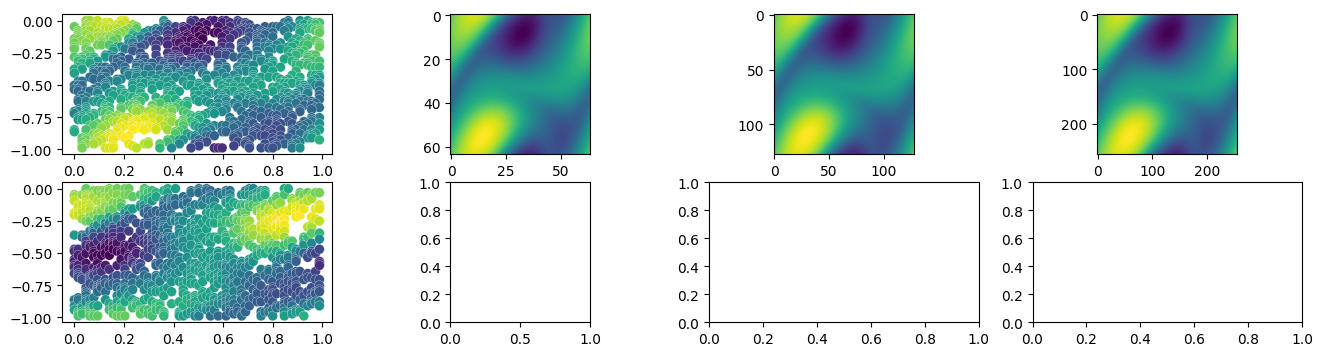

In [25]:
idx2show = [0]
time2show = 20
path = '/home/lise.leboudec/project/coral/xp/vis/'

b_tr = trainset_ext[idx2show]
b1_tr = trainset_up1[idx2show]
b4_tr = trainset_up4[idx2show]
b16_tr = trainset_up16[idx2show]

b_te = trainset_ext[idx2show]
b1_te = trainset_up1[idx2show]
b4_te = trainset_up4[idx2show]
b16_te = trainset_up16[idx2show]

pred_tr_coral = forward_coral(inr, dyn, b_tr, inner_steps, alpha, True, timestamps_ext, z_mean, z_std, dataset_name).cpu().detach().numpy()
pred_tr_coral1 = forward_coral(inr, dyn, b1_tr, inner_steps, alpha, True, timestamps_ext, z_mean, z_std, dataset_name).cpu().detach().numpy()
pred_tr_coral4 = forward_coral(inr, dyn, b4_tr, inner_steps, alpha, True, timestamps_ext, z_mean, z_std, dataset_name).cpu().detach().numpy()
pred_tr_coral16 = forward_coral(inr, dyn, b16_tr, inner_steps, alpha, True, timestamps_ext, z_mean, z_std, dataset_name).cpu().detach().numpy()

# pred_tr_coral1 = einops.rearrange(pred_tr_coral1, 'B  (XY) C T -> B X Y C T', X=64).cpu().detach().numpy()
# b1_tr = einops.rearrange(trainset_up1[idx2show], 'B  (XY) C T -> B X Y C T', X=64).cpu().detach().numpy()

pred_te_coral = forward_coral(inr, dyn, b_te, inner_steps, alpha, True, timestamps_ext, z_mean, z_std, dataset_name).cpu().detach().numpy()
pred_te_coral1 = forward_coral(inr, dyn, b1_te, inner_steps, alpha, True, timestamps_ext, z_mean, z_std, dataset_name).cpu().detach().numpy()
pred_te_coral4 = forward_coral(inr, dyn, b4_te, inner_steps, alpha, True, timestamps_ext, z_mean, z_std, dataset_name).cpu().detach().numpy()
pred_te_coral16 = forward_coral(inr, dyn, b16_te, inner_steps, alpha, True, timestamps_ext, z_mean, z_std, dataset_name).cpu().detach().numpy()

fig, axs = plt.subplots(2, 4, figsize=(16, 4))
# lims = dict(vmin=y_train[i].min(), vmax=y_train[i].max())
# plt.scatter(
#     np.asarray(grid_inp_tr[:, 0]),
#     np.asarray(grid_inp_tr[:, 1]),
#     50,
#     np.asarray(y_train[i, ..., 0]),
#     edgecolor="w",
#     lw=0.2,
#     **lims,
#     )
x = b_tr[2][0, ..., 0, time2show]
y = b_tr[2][0, ..., 1, time2show]
axs[0, 0].scatter(y, -x, 50, b_tr[0][0, ..., time2show], edgecolor="w",
    lw=0.2,)
axs[0, 1].imshow(b1_tr[0][0, ..., time2show].reshape(64, 64))
# axs[0, 0].set_title(f"Prediction, rel mse = {100*pred_test_mse:.2f}%", fontsize=8)
axs[0, 2].imshow(b4_tr[0][0, ..., time2show].reshape(128, 128))
# axs[0, 1].set_title(f"Ground truth", fontsize=8)
axs[0, 3].imshow(b16_tr[0][0, ..., time2show].reshape(256, 256))

axs[1, 0].scatter(x, -y, 50, b_te[0][0, ..., time2show], edgecolor="w",
    lw=0.2,)
axs[1, 1].imshow(pred_tr_coral1[0][0, ..., time2show])
# axs[1, 0].set_title(f"Prediction, rel mse = {100*pred_test_mse:.2f}%", fontsize=8)
axs[1, 2].imshow(pred_tr_coral4[0][0, ..., time2show])
# axs[1, 1].set_title(f"Ground truth", fontsize=8)
axs[1, 3].imshow(pred_tr_coral16[0][0, ..., time2show])
# plt.savefig(os.path.join(plot_dir, 'ns-upsampling64to256.png'), bbox_inches='tight', dpi=300)

fig, axs = plt.subplots(2, 3)
axs[0, 0].imshow(b_te[0][0, ..., time2show])
# axs[0, 0].set_title(f"Prediction, rel mse = {100*pred_test_mse:.2f}%", fontsize=8)
axs[0, 1].imshow(b1_te[0][0, ..., time2show])
axs[0, 2].imshow(b4_te[0][0, ..., time2show])
# axs[0, 1].set_title(f"Ground teuth", fontsize=8)
axs[0, 3].imshow(b16_te[0][0, ..., time2show])
axs[1, 0].imshow(pred_te_coral[0][0, ..., time2show])
# axs[1, 0].set_title(f"Prediction, rel mse = {100*pred_test_mse:.2f}%", fontsize=8)
axs[1, 1].imshow(pred_te_coral1[0][0, ..., time2show])
axs[1, 2].imshow(pred_te_coral4[0][0, ..., time2show])
# axs[1, 1].set_title(f"Ground teuth", fontsize=8)
axs[1, 3].imshow(pred_te_coral16[0][0, ..., time2show])
# plt.savefig(os.path.join(plot_dir, 'ns-upsampling64to256.png'), bbox_inches='tight', dpi=300)

fig, ax = plt.subplots(1, 2)

def animate(i):
    ax[0].imshow(b_te[0][0, ..., i])
    ax[1].imshow(pred_te_coral[0][0, ..., i])
    return ax

ani = FuncAnimation(fig, animate, interval=40, repeat=True, frames=len(T_EXT))
ani.save(path + "vis_test_exp.gif", dpi=300, writer=PillowWriter(fps=25))